In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from transformers import DistilBertConfig,RobertaConfig
from transformers import DistilBertTokenizer,DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification,DistilBertModel
from transformers import TFDistilBertForSequenceClassification,TFDistilBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import os
from tensorflow.keras.layers import Dense,Dropout, Input
from tensorflow.keras import regularizers


import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw= stopwords.words('english')

2023-08-11 14:53:40.261784: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-11 14:53:40.297340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-11 14:53:40.297390: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-11 14:53:44.463185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-11 14:53:44.463205: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to c

In [2]:
train= pd.read_csv('emotion_train.txt',delimiter=';',header=None,names=['sentence','label'])
test= pd.read_csv ('emotion_test.txt',delimiter=';',header=None,names=['sentence','label'])
valid= pd.read_csv('emotion_val.txt',delimiter=';',header=None, names=['sentence','label'])

In [3]:
df=pd.concat([train,test,valid])

In [4]:
df.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
df['encoded_labels'] = df['label'].astype('category').cat.codes

# Analyse semi-supervisé nous a permis d'identifier comme possible variable sensible(taille des phrases): phrase courte Vs phrase longue
#  un seuil fixe <=20 mots: si le mot dans la phrase est <=20, phrase courte S=0 
#                           si le mot dans la phrase est >20, phrase longue S=1 

In [6]:
# Création de la variable sensible dans le jeu de données à l'aide des fonction suivantes

def count_words(sentence, threshold):
    word_count = len(sentence.split())
    if word_count <= threshold:
        return 0
    else:
        return 1

def add_word_count_column(dataset, sentence_column, threshold):
    dataset['sensitive_variable'] = dataset[sentence_column].apply(lambda x: count_words(x, threshold))
    return dataset

In [7]:
df = add_word_count_column(df, 'sentence', 20)

In [8]:
df.head()

,sentence,label,encoded_labels,sensitive_variable
0,i didnt feel humiliated,sadness,4,0
1,i can go from feeling so hopeless to so damned...,sadness,4,1
2,im grabbing a minute to post i feel greedy wrong,anger,0,0
3,i am ever feeling nostalgic about the fireplac...,love,3,0
4,i am feeling grouchy,anger,0,0


In [9]:
# récupération des données du groupe S=0
df_S0=df[df.sensitive_variable == 0]
# récupération des données du groupe S=1
df_S1=df[df.sensitive_variable == 1]

In [10]:
df_S1.head()

,sentence,label,encoded_labels,sensitive_variable
1,i can go from feeling so hopeless to so damned...,sadness,4,1
6,ive been taking or milligrams or times recomme...,surprise,5,1
11,i do feel that running is a divine experience ...,joy,2,1
14,i have immense sympathy with the general point...,joy,2,1
18,i started feeling sentimental about dolls i ha...,sadness,4,1


In [11]:
# Transformation de la variable sentence et encoded_labels en objet liste pour le groupe S=0 etS=1
data_texts_s0= df_S0['sentence'].tolist()
data_label_s0= df_S0['encoded_labels'].tolist()
data_texts_s1= df_S1['sentence'].tolist()
data_label_s1= df_S1['encoded_labels'].tolist()

In [12]:
# Pour le groupe S=0
max_len=512
num_classes_S0=len(df_S0['label'].unique())
sentences_S0=df_S0['sentence'].tolist()
labels_S0=df_S0['encoded_labels']
len(sentences_S0),len(labels_S0)

(12386, 12386)

In [13]:
# Prepare the model input pour S=0
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
input_ids=[]
attention_masks=[]

for sent in sentences_S0:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids = np.asarray(input_ids)
attention_masks = np.array(attention_masks)
labels_S0 = np.array(labels_S0)

/home/titontshiongo/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
# split data 
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels_S0,attention_masks,test_size=0.2)

train_label = np.array([np.array(val) for val in train_label])
val_label = np.array([np.array(val) for val in val_label])

# Création du modèle DistilBert pour le sous-groupe S=0 (phrases courtes)

In [15]:
# Distilbert sans régularisation
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu')(dbert_layer)
    
    #dense = Dense(64,activation='relu',)(dense)
    #taille 64: représentation latente des données
    #dense = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dense)
    #dense = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dense)
    dropout= Dropout(0.5)(dense)
    
    pred = Dense(6, activation='softmax',)(dropout)
    
    model_S0 = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    
    print(model_S0.summary())
    return model_S0  

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [16]:
model_S0=create_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_2[0][0]']                
                                one, 512, 768),                                                   
                                 hidden_states=None                                           

In [18]:
#  learning rate recommandé pourl'optimizer Adam 5e-5, 3e-5, 2e-5: tiré du site Web huggingface

loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

early_stopping= EarlyStopping(patience=3,# stop après 3 epoch
                              monitor='val_loss',# regarder la val_loss
                              mode= 'min',
                              min_delta=0,# changement après 0
                              restore_best_weights=False,
                              verbose=1)

# Entraînement pour le groupe le sous-groupe S=0

In [19]:
model_S0.compile(loss=loss,optimizer=optimizer, metrics=[metric])
history=model_S0.fit([train_inp,train_mask],train_label,batch_size=64,epochs=50,validation_data=([val_inp,val_mask],val_label),callbacks=early_stopping)

Epoch 1/10
155/155 [==============================] - 3562s 23s/step - loss: 0.7668 - accuracy: 0.7216 - val_loss: 0.2404 - val_accuracy: 0.9185
Epoch 2/10
155/155 [==============================] - 3567s 23s/step - loss: 0.1984 - accuracy: 0.9235 - val_loss: 0.1865 - val_accuracy: 0.9262
Epoch 3/10
155/155 [==============================] - 3564s 23s/step - loss: 0.1178 - accuracy: 0.9499 - val_loss: 0.1621 - val_accuracy: 0.9241
Epoch 4/10
155/155 [==============================] - 3562s 23s/step - loss: 0.0978 - accuracy: 0.9580 - val_loss: 0.1612 - val_accuracy: 0.9237
Epoch 5/10
155/155 [==============================] - 3561s 23s/step - loss: 0.0773 - accuracy: 0.9637 - val_loss: 0.2016 - val_accuracy: 0.9282
Epoch 6/10
155/155 [==============================] - 3562s 23s/step - loss: 0.0664 - accuracy: 0.9703 - val_loss: 0.1991 - val_accuracy: 0.9237
Epoch 7/10
155/155 [==============================] - 3562s 23s/step - loss: 0.0599 - accuracy: 0.9735 - val_loss: 0.2237 - val_ac

In [31]:
# sauvergade du modèle
model_S0.save("myModel_S0.h5")

In [20]:
def plot_history(train_history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = train_history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

Lowest Validation Loss: epoch 4
Highest Validation Accuracy: epoch 5


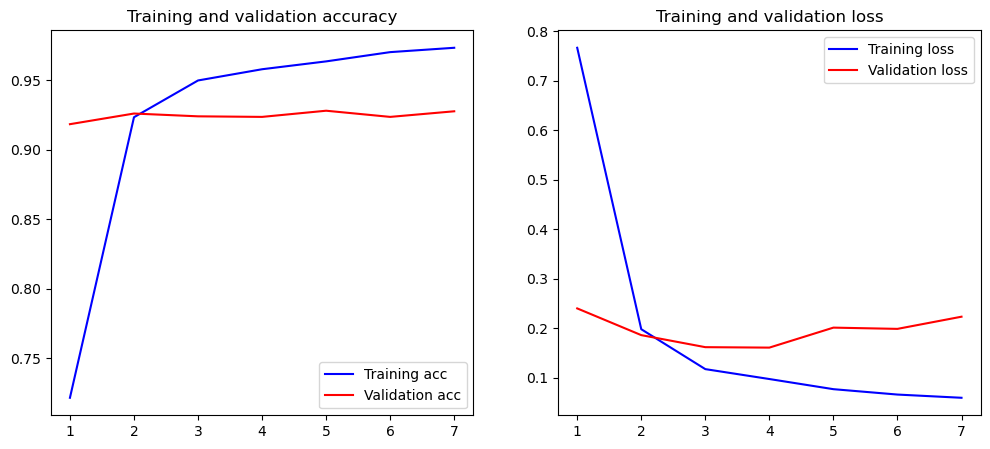

In [21]:

plot_history(history)

In [22]:
preds = model_S0.predict([val_inp,val_mask],batch_size=16)

155/155 [==============================] - 273s 2s/step


In [24]:
pred_labels = preds.argmax(axis=1)

In [25]:
# Rapport de classification avec régularisation

target_names = ['anger', 'love', 'joy', 'fear', 'sadness', 'surprise']
print('Classification Report')
print(classification_report(val_label,pred_labels,target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       anger       0.90      0.94      0.92       345
        love       0.88      0.90      0.89       315
         joy       0.96      0.93      0.95       827
        fear       0.81      0.87      0.83       186
     sadness       0.98      0.96      0.97       739
    surprise       0.71      0.77      0.74        66

    accuracy                           0.93      2478
   macro avg       0.87      0.89      0.88      2478
weighted avg       0.93      0.93      0.93      2478



/tmp/ipykernel_5678/46156137.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


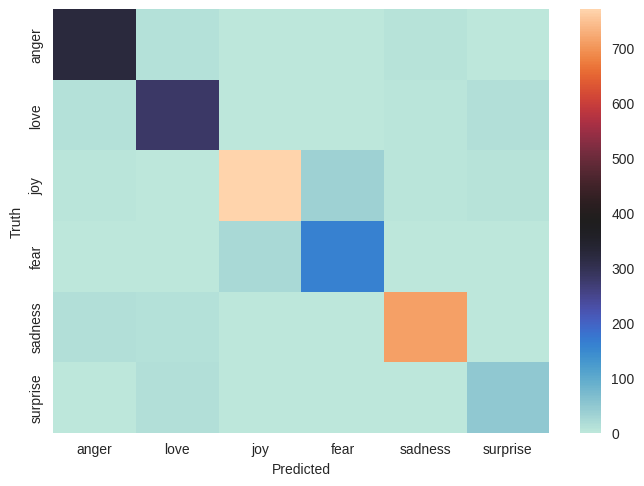

In [34]:


# choix des couleurs: "rocket","crest","mako","flare","magma","coolwarm","icefire","vlag","YlOrBr","cubehelix"

# Matrice de confusion
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

cm = confusion_matrix(val_label,pred_labels,)
# plot confusion matrix
sns.heatmap(cm, annot=False,fmt='d',cmap="icefire",xticklabels=target_names,yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [40]:
# Voir le taux de bonne prédictions VS le taux de mauvaise prédiction dans le sous_groupe S=0
tpr=np.sum((pred_labels.ravel()==1)*(val_label.ravel()==1)) / np.sum(pred_labels.ravel()==1)
tnr=np.sum((pred_labels.ravel()==0)*(val_label.ravel()==0)) / np.sum(pred_labels.ravel()==0)

In [41]:
print("True positive rate =",tpr)
print("True negative rate =",tnr)

True positive rate = 0.8950819672131147
True negative rate = 0.9253731343283582


#  Entraînement Pour le sous-groupe S=1 (Phrase longue)

In [42]:
# Pour le groupe S=1
max_len=512
num_classes_S1=len(df_S1['label'].unique())
sentences_S1=df_S1['sentence'].tolist()
labels_S1=df_S1['encoded_labels']
len(sentences_S1),len(labels_S1)

(7614, 7614)

In [43]:
# Prepare the model input pour S=1
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
input_ids_S1=[]
attention_masks_S1=[]

for sent in sentences_S1:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids_S1.append(dbert_inps['input_ids'])
    attention_masks_S1.append(dbert_inps['attention_mask'])

input_ids_S1 = np.asarray(input_ids_S1)
attention_masks_S1 = np.array(attention_masks_S1)
labels_S1 = np.array(labels_S1)

/home/titontshiongo/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [44]:
# split data 
train_inp_S1,val_inp_S1,train_label_S1,val_label_S1,train_mask_S1,val_mask_S1=train_test_split(input_ids_S1,labels_S1,attention_masks_S1,test_size=0.2)

train_label_S1 = np.array([np.array(val) for val in train_label_S1])
val_label_S1 = np.array([np.array(val) for val in val_label_S1])

In [49]:
# Distilbert sans régularisation
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu')(dbert_layer)
    
    #dense = Dense(64,activation='relu',)(dense)
    #taille 64: représentation latente des données
    #dense = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dense)
    #dense = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dense)
    dropout= Dropout(0.5)(dense)
    
    pred = Dense(6, activation='softmax',)(dropout)
    
    model_S1 = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    
    print(model_S1.summary())
    return model_S1 

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [50]:
model_S1=create_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model_4 (TFDist  TFBaseModelOutput(l  66362880   ['input_7[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_8[0][0]']                
                                one, 512, 768),                                                   
                                 hidden_states=None                                         

In [51]:
#  learning rate recommandé pourl'optimizer Adam 5e-5, 3e-5, 2e-5: tiré du site Web huggingface

loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

early_stopping= EarlyStopping(patience=2,# stop après 3 epoch
                              monitor='val_loss',# regarder la val_loss
                              mode= 'min',
                              min_delta=0,# changement après 0
                              restore_best_weights=False,
                              verbose=1)

In [52]:
model_S1.compile(loss=loss,optimizer=optimizer, metrics=[metric])
history=model_S1.fit([train_inp_S1,train_mask_S1],train_label_S1,batch_size=64,epochs=10,validation_data=([val_inp_S1,val_mask_S1],val_label_S1),callbacks=early_stopping)

Epoch 1/10
96/96 [==============================] - 2200s 23s/step - loss: 1.1792 - accuracy: 0.5649 - val_loss: 0.5820 - val_accuracy: 0.7846
Epoch 2/10
96/96 [==============================] - 2200s 23s/step - loss: 0.3950 - accuracy: 0.8688 - val_loss: 0.2208 - val_accuracy: 0.9166
Epoch 3/10
96/96 [==============================] - 2224s 23s/step - loss: 0.1890 - accuracy: 0.9312 - val_loss: 0.1938 - val_accuracy: 0.9186
Epoch 4/10
96/96 [==============================] - 2212s 23s/step - loss: 0.1241 - accuracy: 0.9519 - val_loss: 0.1812 - val_accuracy: 0.9343
Epoch 5/10
96/96 [==============================] - 2225s 23s/step - loss: 0.0943 - accuracy: 0.9621 - val_loss: 0.1988 - val_accuracy: 0.9304
Epoch 6/10
96/96 [==============================] - 2242s 23s/step - loss: 0.0781 - accuracy: 0.9688 - val_loss: 0.2361 - val_accuracy: 0.9357
Epoch 6: early stopping


In [53]:
# sauvergade du modèle
model_S1.save("myModel_S1.h5")

In [54]:
def plot_history(train_history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = train_history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    print("Lowest Validation Loss: epoch {}".format(np.argmin(val_loss)+1))
    print("Highest Validation Accuracy: epoch {}".format(np.argmax(val_acc)+1))

Lowest Validation Loss: epoch 4
Highest Validation Accuracy: epoch 6


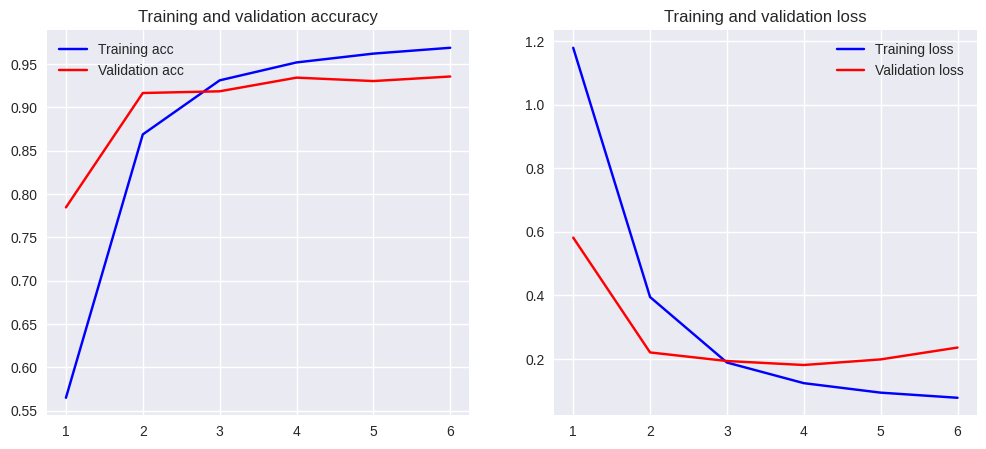

In [55]:

plot_history(history)

In [56]:
preds_S1 = model_S1.predict([val_inp_S1,val_mask_S1],batch_size=16)

96/96 [==============================] - 167s 2s/step


In [57]:
pred_labels_S1 = preds_S1.argmax(axis=1)

In [58]:
# Rapport de classification avec régularisation

target_names = ['anger', 'love', 'joy', 'fear', 'sadness', 'surprise']
print('Classification Report')
print(classification_report(val_label_S1,pred_labels_S1,target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       anger       0.93      0.95      0.94       199
        love       0.89      0.95      0.92       170
         joy       0.93      0.97      0.95       535
        fear       0.91      0.82      0.86       146
     sadness       0.98      0.94      0.96       423
    surprise       0.97      0.68      0.80        50

    accuracy                           0.94      1523
   macro avg       0.93      0.89      0.91      1523
weighted avg       0.94      0.94      0.93      1523



/tmp/ipykernel_5440/1214284912.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


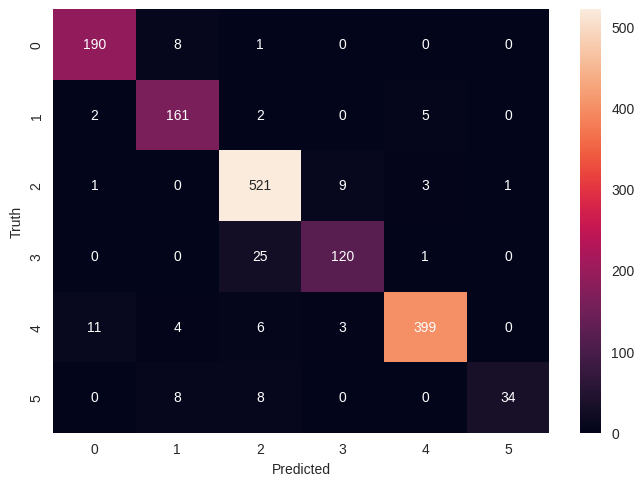

In [59]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

cm = confusion_matrix(val_label_S1,pred_labels_S1,)
# plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d',)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [60]:
# Voir le taux de bonne prédictions VS le taux de mauvaise prédiction dans le sous_groupe S=1
tpr=np.sum((pred_labels_S1.ravel()==1)*(val_label_S1.ravel()==1)) / np.sum(pred_labels_S1.ravel()==1)
tnr=np.sum((pred_labels_S1.ravel()==0)*(val_label_S1.ravel()==0)) / np.sum(pred_labels_S1.ravel()==0)

In [61]:
print("True positive rate =",tpr)
print("True negative rate =",tnr)

True positive rate = 0.8895027624309392
True negative rate = 0.9313725490196079
